In [1]:
from agents.ppo import Agent, ReplayData, ExperimentReplayBuffer
from networks.vit import VIT3_FC
import matplotlib.pyplot as plt
from  env.guide_sim import GuidewireEnv
from env.metadata import GuideSimMetadata, HyperParams
import torch
import torchvision.transforms as transforms
import numpy as np 
import random
import os
from tqdm import tqdm

pygame-ce 2.5.0 (SDL 2.30.3, Python 3.10.0)


In [2]:
dataset_path = "datas/exvivo/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]

In [3]:
hyper = HyperParams()
hyper.load_from_json("./hyper.json")

Key 'A*DenseReward' not found in GuideSimMetadata class.
Key 'L2DenseReward' not found in GuideSimMetadata class.


In [4]:
class SubEnv:
    """
    管理每个独立进程中的游戏环境
    每个进程会维护n个环境
    通过传入的tasks列表来创建环境
    环境使用串行方式来执行
    """
    def __init__(self, tasks, hyper_params:HyperParams):
        self.tasks = tasks
        self.envs = [GuidewireEnv(task) for task in tasks]
        self.dones = [False for _ in range(len(tasks))]
        self.hyper_params = hyper_params
        for env in self.envs:
            env.hyper_params = hyper_params
        self.last_states = []
        self.episode_buffer = [ReplayData() for _ in range(len(tasks))]
        self.replay_buffer = ExperimentReplayBuffer()

    # 重启环境
    def reset(self, transfrom: transforms.Compose) -> np.ndarray:
        """对每个子环境重置并且收集状态"""
        self.last_states = []
        states = None
        for k, env in enumerate(self.envs):
            s = env.reset()
            self.last_states.append(s)
            if states is None:
                states = np.zeros((len(self.tasks), *s.shape))
            states[k, ...] = s
        self.dones = [False for _ in range(len(self.tasks))]
        # 域随机化
        states = transfrom(
                torch.tensor(states, dtype=torch.uint8))
        states = states.numpy()
        return states

    # 环境执行一步
    def step(self, actions:list[int], 
             probs:list[float],
             values:list[float],
             transfrom: transforms.Compose):
        """对每个子环境串行执行操作并且收集状态"""
        states = []
        for k, env in enumerate(self.envs):
            s_next, r, d, _ = env.step(actions[k])
            self.episode_buffer[k].pack_step_data(self.last_states[k], 
                                                  actions[k], 
                                                  probs[k],
                                                  r,
                                                  values[k],
                                                  d)
            if d:  # 策略是如果结束了直接开一局新的
                s_next = env.reset()
                self.replay_buffer.pack_episode_data(self.episode_buffer[k],
                                                     self.hyper_params.lambda_,
                                                     self.hyper_params.gamma)
            # 域随机化
            s_next = transfrom(
                    torch.tensor(s_next, dtype=torch.uint8))
            s_next = s_next.numpy()

            states.append(s_next)
        self.last_states = states
        return np.array(states)
    
    def evaler(self, agent:Agent, transfrom: transforms.Compose):
        """评估模型，对所有的子环境都进行完整交互并且返回消耗步数和奖励"""
        agent.ac_model.eval()
        states = self.reset(transfrom)
        rewards = []
        steps = []
        out_states = []
        for k, env in enumerate(self.envs):
            num_steps = 0
            for _ in range(self.hyper_params.max_steps):
                a, _,_ = agent.desision(states[k])
                state, reward, done, _ = env.step(a)

                # 域随机化
                state = transfrom(
                    torch.tensor(state, dtype=torch.uint8))
                state = state.numpy()
                # 回到numpy
                states[k] = state

                num_steps += 1
                if done:
                    print(f"[eval] ID {k}: {env.task_path} done.")
                    print(f"\treward: {reward}, steps: {num_steps}")
                    rewards.append(reward)
                    steps.append(num_steps)
                    out_states.append(state)
                    break     
        return out_states, np.mean(steps), np.mean(rewards)

def img_ploter(states:np.ndarray) -> plt.Figure:
    """将状态画成图，用于暂存到tensorboard中"""
    num_figs = 0
    if isinstance(states, np.ndarray):
        num_figs = states.shape[0]
    elif isinstance(states, list):
        num_figs = len(states)
    num_rows = num_figs // 5 + 1
    # 生成5列n行的子图
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
    now_row = 0
    for i, state in enumerate(states):
        # 每5个子图后换行
        axs[now_row, i%5].imshow(state[0], cmap="gray")
        axs[now_row, i%5].axis('off')
        if i%5 == 4:
            now_row += 1
    return fig


## 创建批量交互器

In [5]:
se = SubEnv(tasks, hyper)

## 加载模型与PPO Agent

In [6]:
model = VIT3_FC()
count = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {count}")
agent = Agent(model)
agent.ac_model = model.to(agent.device)
agent.set_hyperpara(hyper)
agent.plot_attrs()
# 加载模型权重
weight_path = os.path.join("./weights", hyper.task_name)
last_epo = 0
if agent.load(os.path.join(weight_path, "last.pth"),'cuda:0'):
    last_epo = int(agent.epoch)
    print("weight loaded")
else:
    print("weight not loaded")

Total number of parameters: 27369478
cuda:0
Agent's attributes:
----------------------
batch_size :		 5
beta :		 0.02
c_coef :		 1.0
device :		 cuda:0
epoch :		 0
epsilon :		 0.2
exp_reuse_rate :		 3
gamma :		 0.98
lambda_ :		 0.99
lr :		 1e-06
optim_type :		 adam
optm :		 None
----------------------
weight loaded


c:\Users\m9291\.conda\envs\torch\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


# 一轮交互与收集过程

In [7]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 无域随机化的普通转换管道
transform_norm = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化到[-1, 1]之间
])


c:\Users\m9291\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


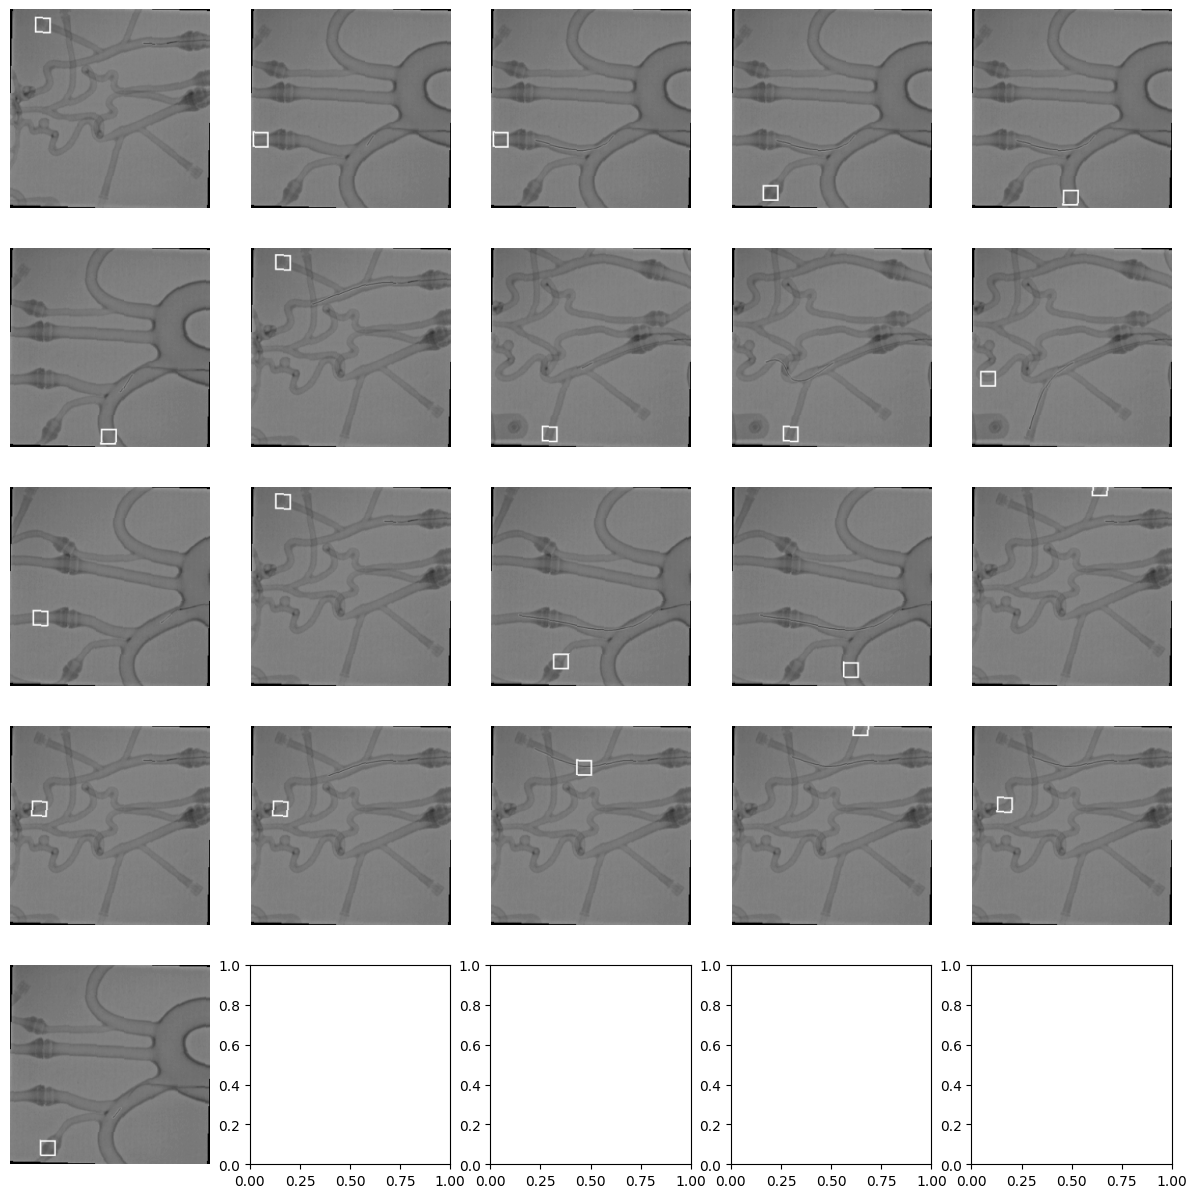

In [8]:
states = se.reset(transform)
fig = img_ploter(states)
plt.show()

In [9]:
states = se.reset(transform)

for _ in tqdm(range(hyper.max_steps)):
    batch_a_tensor, batch_p_tensor, batch_v_tensor, _ = agent.batch_desision(states)
    batch_a = batch_a_tensor.squeeze(1).tolist()
    batch_p = batch_p_tensor.squeeze(1).tolist()
    batch_v = batch_v_tensor.squeeze(1).tolist()
    states = se.step(batch_a, batch_p, batch_v, transform)


100%|██████████| 80/80 [02:13<00:00,  1.66s/it]


In [10]:
s, step, r, = se.evaler(agent, transform_norm)

[eval] ID 0: datas/exvivo/task\1.json done.
	reward: 1.0817551716016867, steps: 80
[eval] ID 1: datas/exvivo/task\10.json done.
	reward: 1.1874435023747254, steps: 80
[eval] ID 2: datas/exvivo/task\11.json done.
	reward: 2.312635428847547, steps: 80
[eval] ID 3: datas/exvivo/task\12.json done.
	reward: 1.258781040820931, steps: 80
[eval] ID 4: datas/exvivo/task\13.json done.
	reward: 1.7429693050586228, steps: 80
[eval] ID 5: datas/exvivo/task\14.json done.
	reward: 1.973281345851445, steps: 80
[eval] ID 6: datas/exvivo/task\15.json done.
	reward: 1.6044503709230613, steps: 80
[eval] ID 7: datas/exvivo/task\16.json done.
	reward: 1.3664917338237108, steps: 80
[eval] ID 8: datas/exvivo/task\17.json done.
	reward: 1.2344320118106447, steps: 80
[eval] ID 9: datas/exvivo/task\18.json done.
	reward: 1.4146938356415886, steps: 80
[eval] ID 10: datas/exvivo/task\19.json done.
	reward: 1.0584304990352777, steps: 80
[eval] ID 11: datas/exvivo/task\2.json done.
	reward: 1.1583622930738837, steps

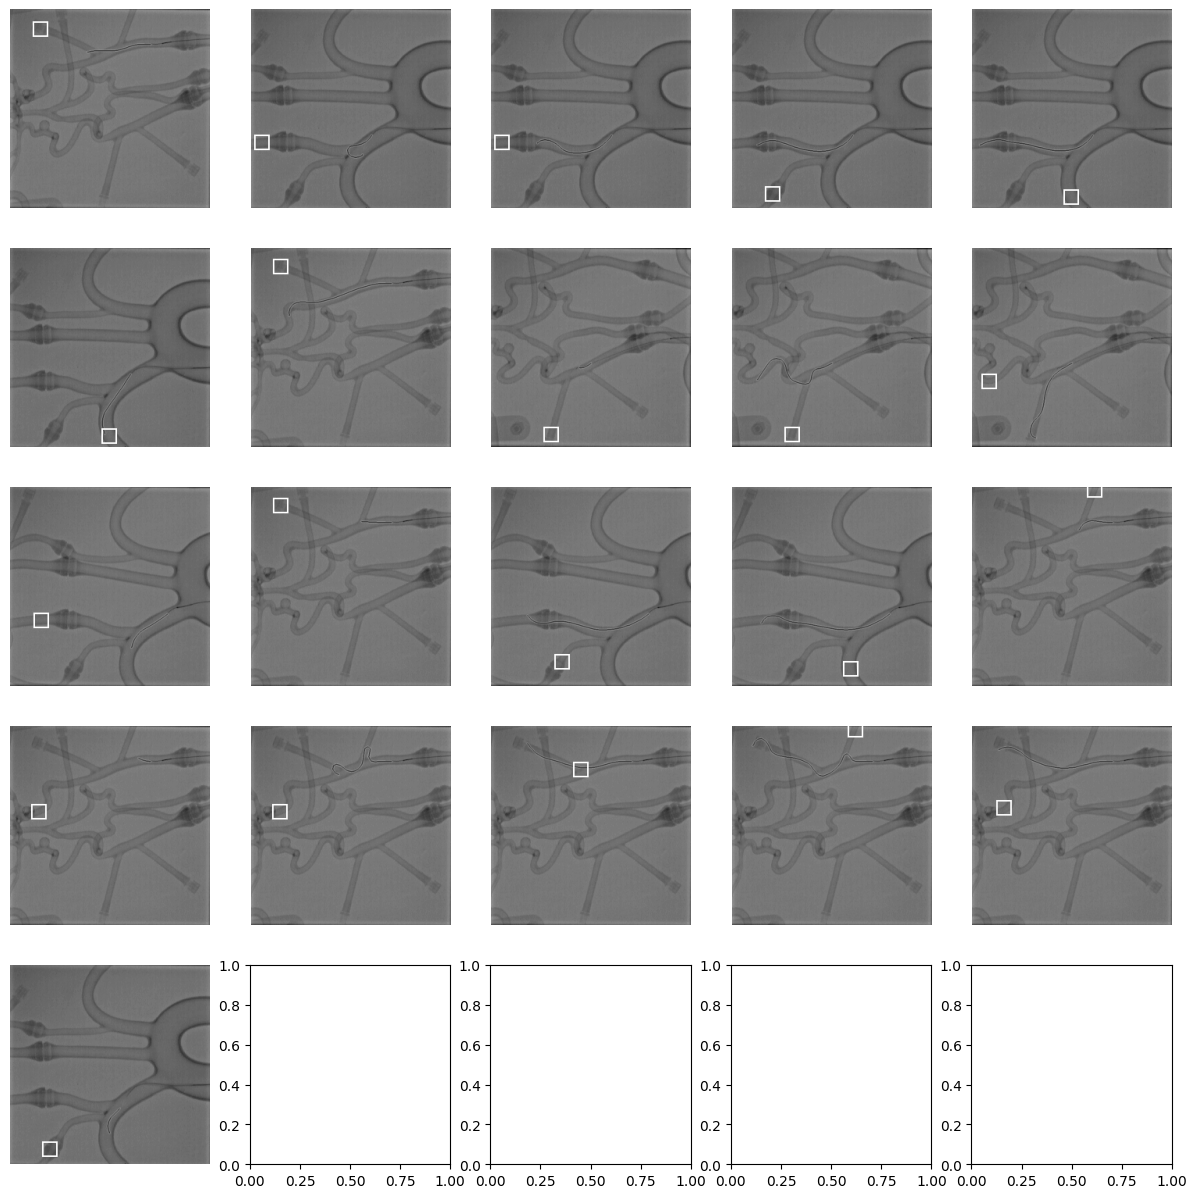

In [14]:
img_ploter(np.array(s))
plt.show()

In [7]:
import cv2
img = cv2.imread("./supervised_datas\\train\\affordance\\1.png", cv2.IMREAD_GRAYSCALE)

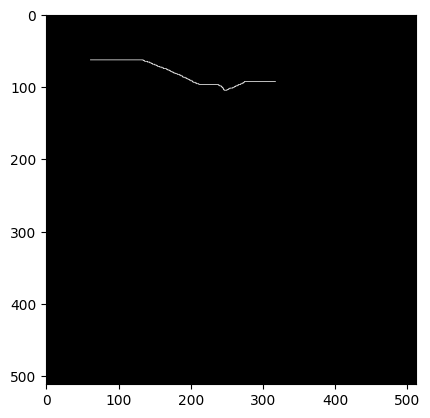

In [8]:
plt.imshow(img, cmap="gray")